In [41]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

fig_DIR = "../figs/shots/"
data_DIR = "../data/ShotLocationData/"
pbp_DIR ="../data/pbpdata/"

bball_gray = "#312f30"
bball_white = "#dddee0"
bball_orange = "#f87c24"
bball_light_orange = "#fbaf7b"
bball_black = "#000010"
dark_grey = "#282828"
fontsize = 28
title_size = 48

In [59]:
league = "NBA"
season = "2024"
from_year = int(season)
year = season + "-" + str(int(season)+1)[-2:]

In [ ]:
with zstd.open(pbp_DIR + league+"_PBPdata_" + season + ".pkl.zst","rb") as f:
    games_list = dill.load(f)
player_dict = get_players_pbp(league=league)  # Creating Player Dictionary
team_dict = nba_teams.get_teams()  # Creating Team Dictionary

In [43]:
possessions = [game.possessions.items for game in games_list]
possession_events = list(chain(*[possession.events for possession in list(chain(*possessions))]))

In [44]:
shot_variables = [
    "game_id",
    "clock",
    "player1_id",
    "team_id",
    "distance",
    "locX",
    "locY",
    "shot_value",
    "shot_type",
    "is_and1",
    "is_assisted",
    "is_blocked",
    "is_corner_3",
    "is_heave",
    "is_made",
    "is_putback",
    "player2_id",
    "period",
    "score_margin",
    "seconds_remaining",
    "seconds_since_previous_event",
]

In [45]:
def set_dtypes(df):
    for col in df.columns:
        if "is_" in col:
            df[col] = df[col].astype(bool)
        elif "_id" in col:
            df[col] = df[col].astype(int)
    if df["clock"].dtype == "O":
        mask = ~df["clock"].str.contains(r"\.")
        df.loc[mask, "clock"] = df.loc[mask, "clock"].apply(lambda x: x + ".0")
        df["clock"] = pd.to_datetime(df["clock"], format="%M:%S.%f").dt.time
    return df

In [55]:
poss_store = []
for possession_event in possession_events:
    if (
        isinstance(possession_event, Foul)
        and 
            isinstance(possession_event.previous_event, FieldGoal)
    ):
        poss = {}
        for var in shot_variables:
            try:
                poss[var] = getattr(possession_event.previous_event, var)
            except:
                poss[var] = 0
        poss_store.append(poss)

In [56]:
df = pd.DataFrame(poss_store)
df = df.rename(columns={"player1_id": "player_id", "player2_id": "player_ast_id"})
df["player_name"] = df["player_id"].map(player_dict)
df["player_ast_name"] = df["player_ast_id"].map(player_dict)

In [77]:
def plot_heatmap_player(player,data):

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    d1 = 15
    d2 = 22
    t1 = 12
    t2 = 16
    cond1 = data["player_name"] == player

    cond2 = data["shot_type"] != "AtRim"
    cond3 = data["distance"] >= d1
    cond4 = data["distance"] < d2
    cond5 = data["seconds_since_previous_event"] >= 24
    cond6 = data["seconds_since_previous_event"] <= 37
    cond7 = (data["shot_type"] == "Arc3") | (data["shot_type"] == "Corner3")
    cond9 = data["player_ast_name"] == player
    cond0 = data["is_made"] == True
    
    shots_df = data[cond1]
    shots_df = data[cond1]
    # shots_df = data[cond1 & cond7 & cond0 ]
    player_id = shots_df["player_id"].iloc[1]
    # player_id = shots_df['player_ast_id'].iloc[1]
    # shots_df = shots_df.sample(frac=0.5)
    ax.set_xlim(252, -252)
    ax.set_ylim(-50, 423)
    ax.set_facecolor(bball_black)
    fig.set_facecolor(bball_black)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    draw_court(ax=ax, outer_lines=True, lw=3, color=bball_orange)
    sns.kdeplot(
        x=shots_df.locX, y=shots_df.locY, fill=True, cmap="inferno", levels=21, ax=ax
    )
    ax.scatter(x=shots_df.locX, y=shots_df.locY, facecolors="w", s=5, linewidths=0.5)

    ax.text(
        x=+180, y=-65, s="@sradjoker", color=bball_white, fontsize=fontsize, ha="center"
    )
    ax.text(
        x=-180,
        y=-65,
        s="Source:pbpstats",
        color=bball_white,
        fontsize=fontsize,
        ha="center",
    )
    try:
        target_dir = "player_imgs"
        if f"{player_id}.png" not in os.listdir(target_dir):
            if league == "NBA":
                url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
            elif league == "WNBA":
                url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/wnba/{player_id}.png"
            response = requests.get(url)
            with open(f"player_imgs/{player_id}.png", "wb") as f:
                f.write(response.content)
        if league == "NBA":
            size = 1.0
        elif league == "WNBA":
            size = 0.4
        ab = AnnotationBbox(
            OffsetImage(plt.imread(f"player_imgs/{player_id}.png"), size=size),
            (-195, 380),
            frameon=False,
        )
        ax.add_artist(ab)
    except:
        pass
    # ax.set_title('Shot Heat Map: Distance (ft) > {0} '.format(d1,d2), size=title_size, color='Orange')
    # ax.set_title('Shot Heat Map: {0} < Distance (ft) < {1}'.format(d1,d2), size=title_size, color='Orange')
    # plt.savefig('Shot_Heat_Map_dis_{0}_{1}.png'.format(d1,d2), bbox_inches='tight', facecolor=bball_black,dpi=300)
    if league == "NBA":
        ax.text(
            x=180,
            y=400,
            s="{0}-{1} NBA".format(from_year, from_year + 1),
            color="White",
            fontsize=fontsize,
            ha="center",
            va="bottom",
        )
    elif league == "WNBA":
        ax.text(
            x=180,
            y=400,
            s=f"{from_year} WNBA",
            color="White",
            fontsize=fontsize,
            ha="center",
            va="bottom",
        )
    ax.text(
        x=180,
        y=380,
        s="Regular Season",
        color="White",
        fontsize=fontsize,
        ha="center",
        va="bottom",
    )
    # ax.text(x=-180, y=400, s="Makes Only", color='White', fontsize=fontsize, ha='center',va='bottom')
    # ax.text(x=-180, y=380, s="Non-Rim Attempts", color='White', fontsize=fontsize, ha='center',va='bottom')
    ax.set_title(f"Free Throw Heat Map: {player}", size=title_size, color="Orange")
    plt.savefig(
        fig_DIR + f"FreeThrow_Heat_Map_{player}_{from_year}.png",
        bbox_inches="tight",
        facecolor=bball_black,
        dpi=300,
    )
    plt.show()

In [94]:
player = "Giannis Antetokounmpo"

In [95]:
# cond1 = df["player_name"] == player
# df[cond1]

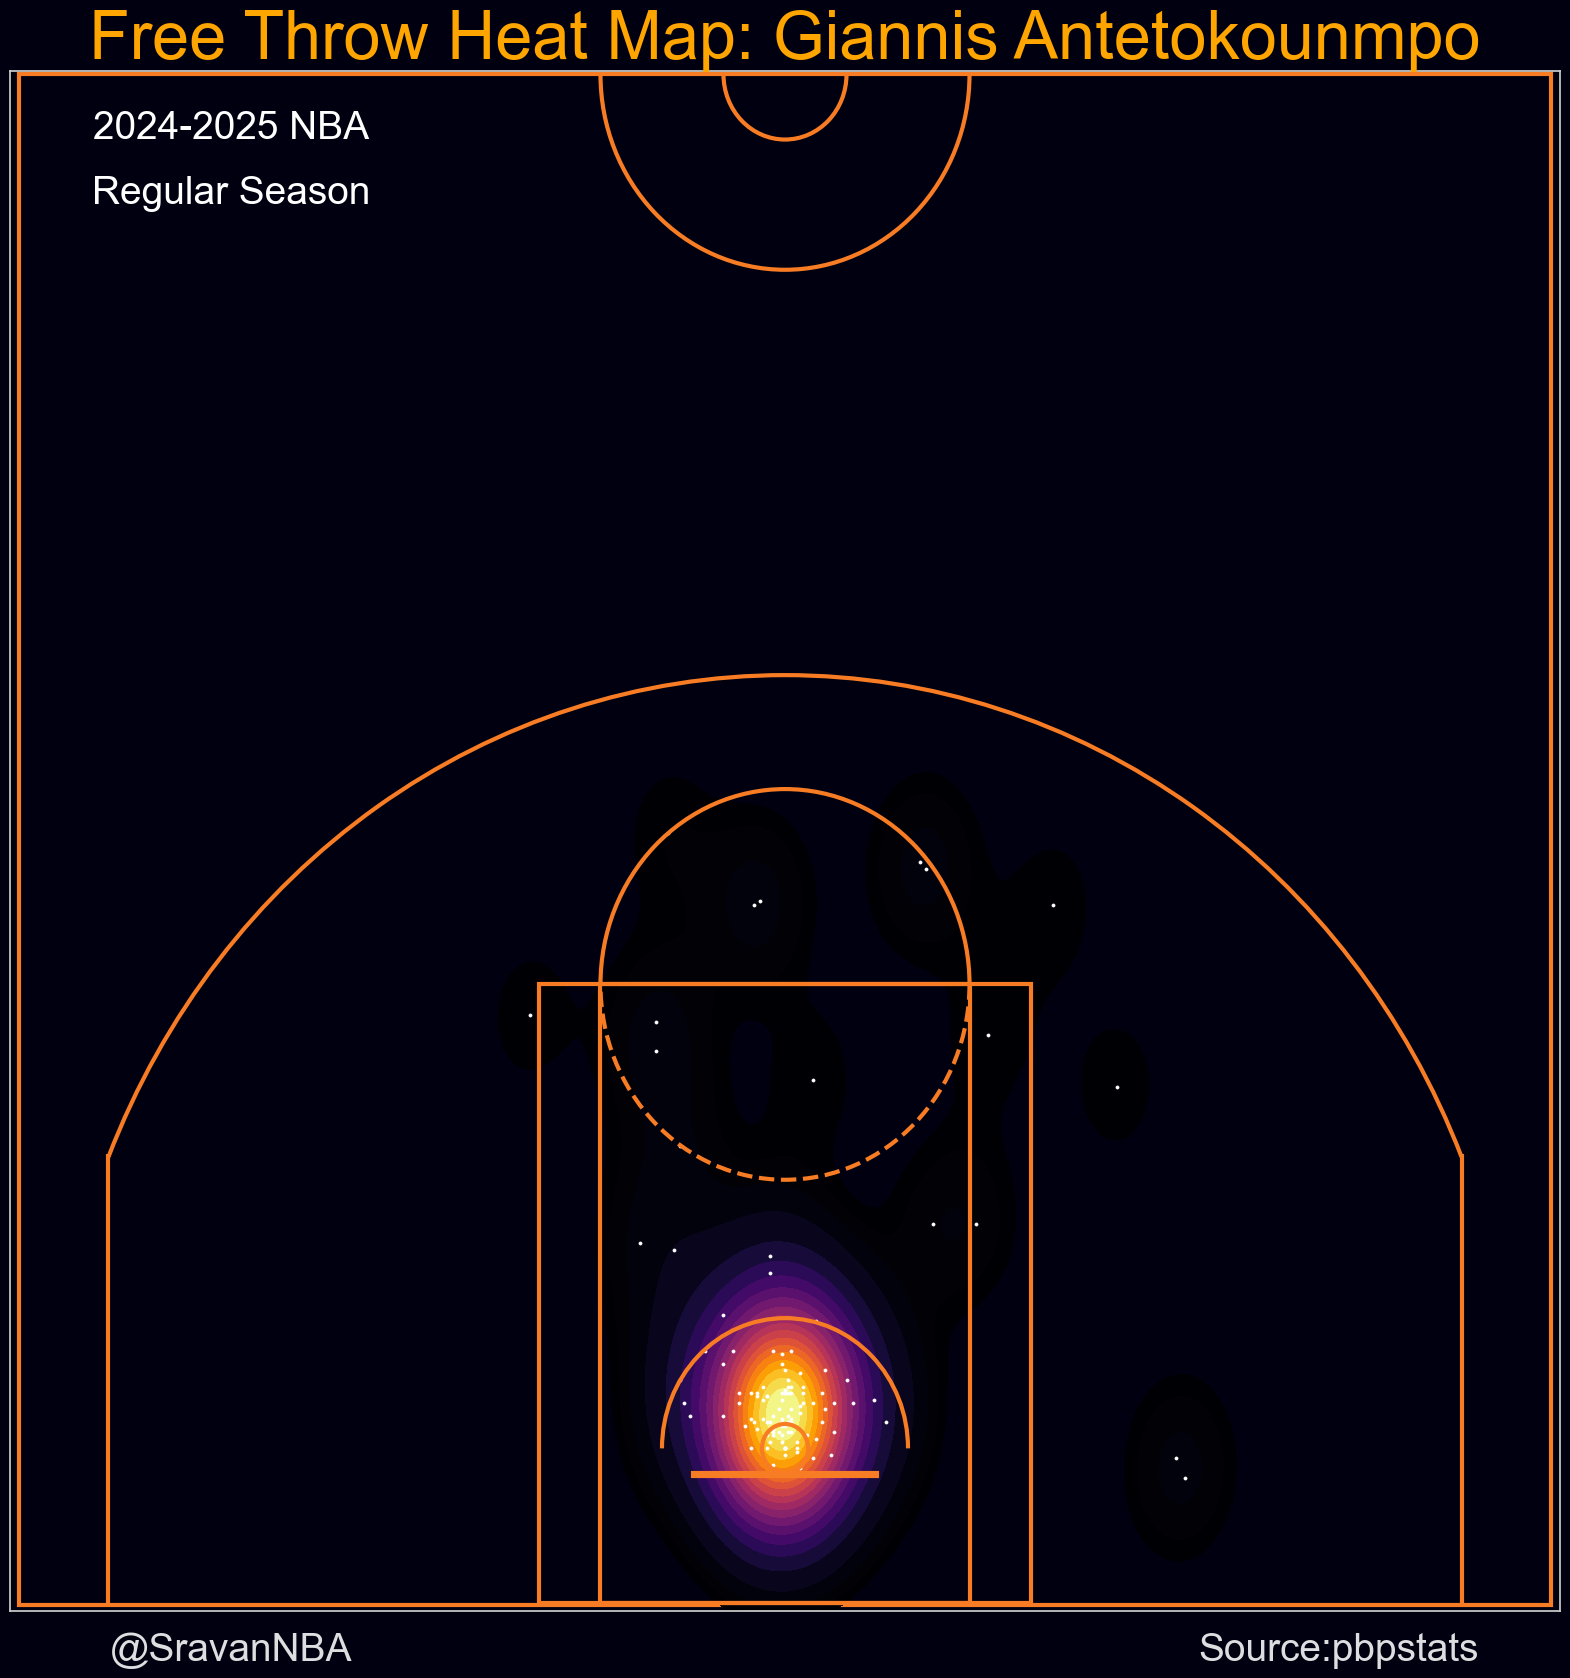

In [96]:
plot_heatmap_player(player,df)